In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import warnings

warnings.filterwarnings('ignore')

PATH_GEOJSON = 'https://raw.githubusercontent.com/dosm-malaysia/data-open/main/datasets/geodata/'
PATH_CENSUS = 'https://raw.githubusercontent.com/dosm-malaysia/data-open/main/datasets/census/'

In [2]:
use_vars = ['poverty_incidence','utilities_pipedwater_home','utilities_electricity_home','population_total','area_km2']
plot_vars = use_vars[:-1]
plot_colors = dict(zip(plot_vars,['Reds','Blues','viridis','RdPu']))
plot_titles = dict(zip(plot_vars, ['Incidence of Poverty (%)',
                                'Access to Piped Water at Home (%)',
                                'Access to Electricity at Home (%)',
                                'Population Density (people per km^2)']))


df = pd.read_csv(PATH_CENSUS + 'census_parlimen.csv',usecols=['parlimen'] + use_vars)
df.population_total /= df.area_km2
df.drop(['area_km2'],axis=1,inplace=True)
df.head()

,parlimen,population_total,poverty_incidence,utilities_pipedwater_home,utilities_electricity_home
0,P.001 Padang Besar,192.884444,5.7,99.7,100.0
1,P.002 Kangar,714.574468,4.2,99.4,100.0
2,P.003 Arau,438.432432,1.4,99.8,100.0
3,P.004 Langkawi,200.720682,0.9,99.5,100.0
4,P.005 Jerlun,209.132911,6.7,99.0,100.0


In [3]:
geo_state = gpd.read_file(PATH_GEOJSON + 'administrative_1_state.geojson')
geo_parl = gpd.read_file(PATH_GEOJSON + 'electoral_0_parlimen.geojson')

# This step moves peninsular Malaysia to create a more visually compact map - comment out if you want original map
for temp,name in zip([geo_state,geo_parl],['state','parlimen','dun']):
    temp.loc[~temp.code_state.isin([12, 13, 15]), 'geometry'] = temp.geometry.translate(9, 4.5)

geo_parl = pd.merge(geo_parl,df,on='parlimen',how='left')
geo_parl.head()

,state,parlimen,code_state,code_parlimen,geometry,population_total,poverty_incidence,utilities_pipedwater_home,utilities_electricity_home
0,Perlis,P.001 Padang Besar,9,P.001,"MULTIPOLYGON (((109.20513 11.22227, 109.20778 ...",192.884444,5.7,99.7,100.0
1,Perlis,P.002 Kangar,9,P.002,"MULTIPOLYGON (((109.16465 11.07050, 109.16618 ...",714.574468,4.2,99.4,100.0
2,Perlis,P.003 Arau,9,P.003,"MULTIPOLYGON (((109.36581 10.98322, 109.36314 ...",438.432432,1.4,99.8,100.0
3,Kedah,P.004 Langkawi,2,P.004,"MULTIPOLYGON (((108.79701 10.65851, 108.79812 ...",200.720682,0.9,99.5,100.0
4,Kedah,P.005 Jerlun,2,P.005,"MULTIPOLYGON (((109.35617 10.94752, 109.35880 ...",209.132911,6.7,99.0,100.0


In [4]:
plt.rcParams.update({'font.size': 13,
                     'font.family':'sans-serif',
                     'grid.linestyle': 'dotted',
                     'figure.figsize': [8,8],
                     'figure.autolayout': True})

def heatmap_parlimen(v):
    fig, ax = plt.subplots()
    ax.axis('off')

    vmin,vmax = geo_parl[v].min(),geo_parl[v].max()
    cmap = plot_colors[v]
    geo_parl.plot(column=v, cmap=cmap, vmin=vmin, vmax=vmax, linewidth=0.1, edgecolor='#f2f2f2', ax=ax)
    geo_state.plot(edgecolor='black', linewidth=1, facecolor='none', ax=ax)
    cbar_ax = fig.add_axes([0.1, 0.01, 0.8, 0.02])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax, orientation="horizontal")
    plt.suptitle('MyCensus 2020 (Parlimen): ' + plot_titles[v])
    plt.show()

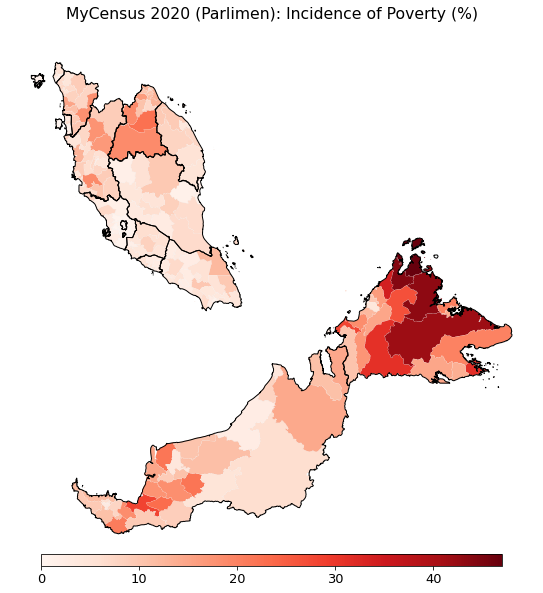

In [5]:
heatmap_parlimen(plot_vars[0])

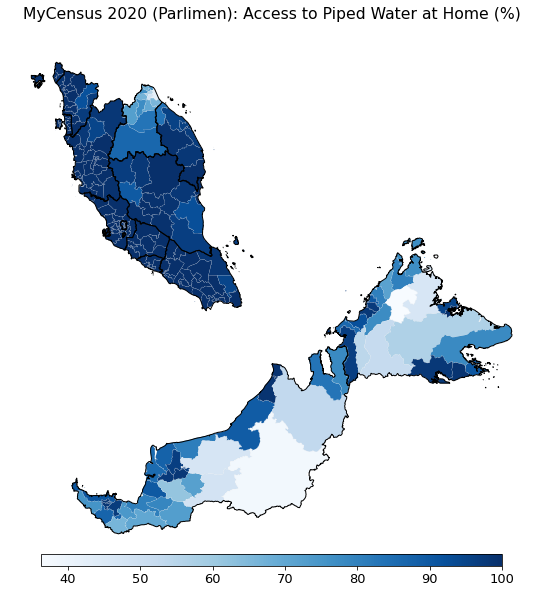

In [6]:
heatmap_parlimen(plot_vars[1])

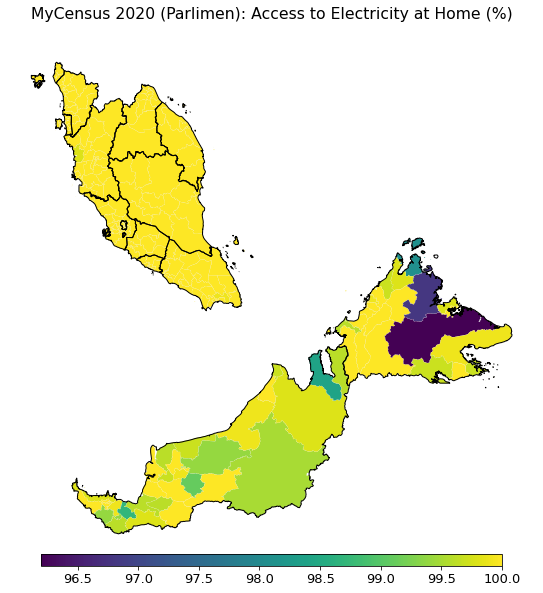

In [7]:
heatmap_parlimen(plot_vars[2])

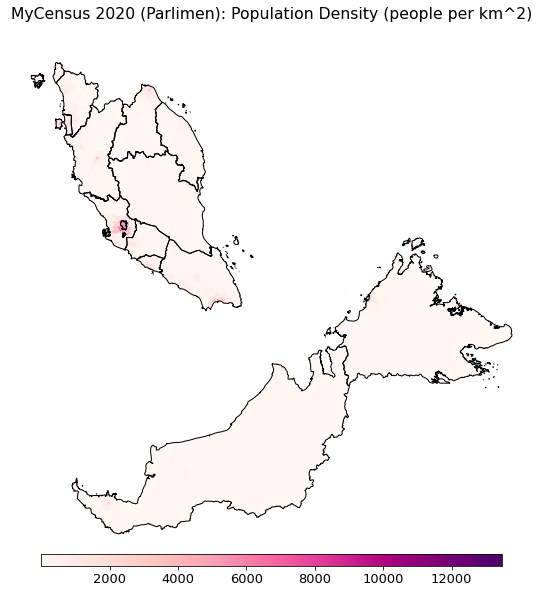

In [8]:
heatmap_parlimen(plot_vars[3])

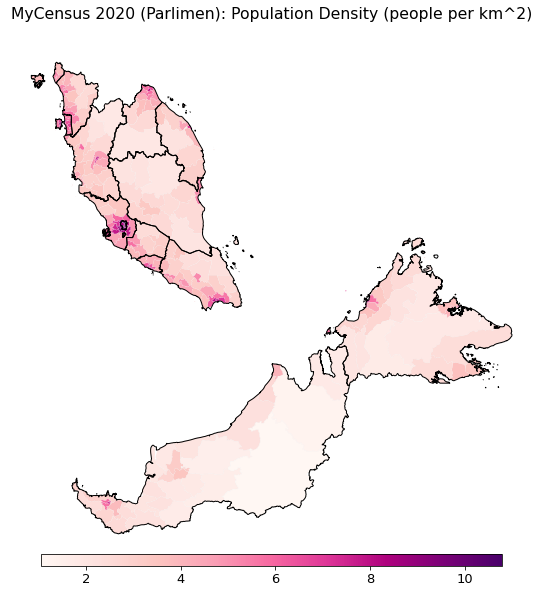

In [9]:
# Due to the extreme density in the Klang Valley, the density heatmap is not very satisfying. 
# We can instead try to plot the 4th root of the value (arbitrary value found through trial and error).
# The urban centres of Malaysia should now show up; look for KK, Kuching, Kota Bharu, Kuala Trg, Ipoh, Alor Setar, etc.
# In addition, with the non-linear scaling, the difference between Peninsular and East Msia becomes more pronounced. 

v = 'population_total'
geo_parl[v] = np.power(geo_parl[v],1/4)
heatmap_parlimen(v)